# Final Project CPSC 381: Introduction to Machine learning
Diego Aspinwall, Ethan Mathieu, Taimur Moolji

# 01: Data Loading + Cleaning

In [89]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

GREEN = "#56D6B3"
BLUE = "#636FFA"
RED = "#ED8375"

## 01-A: Loading Oil Data

In [90]:
# Data load + formatting from the CSV
def load_WTI_data():
    path_name = "./Cushing_OK_WTI_Spot_Price_FOB_20200619.csv" # NOTE: Replace with your filepath
    df = pd.read_csv(path_name, header=4, parse_dates=[0])
    df.columns=["Date", "WTI"]
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

WTI = load_WTI_data()

In [91]:
# Data load + formatting from the CSV
def load_Brent_data():
    path_name = "./BrentOilPrices.csv" # NOTE: Replace with your filepath
    df = pd.read_csv(path_name, parse_dates=[0])
    df.columns=["Date", "Brent"]
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

brent = load_Brent_data()


/var/folders/s9/9qvmt1mj2js561r19jj87dj40000gn/T/ipykernel_26575/3959127350.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path_name, parse_dates=[0])


In [92]:
# Combine the two price series into a single dataframe
oil_data = pd.merge(WTI, brent, left_index=True, right_index=True, how= "inner")
oil_data["Spread"] = oil_data["WTI"] - oil_data["Brent"]
oil_data["WTI_Daily_Change"] = oil_data["WTI"].pct_change()
oil_data["Brent_Daily_Change"] = oil_data["Brent"].pct_change()


### 01-A1: EDA of Oil Prices and Spread over Time

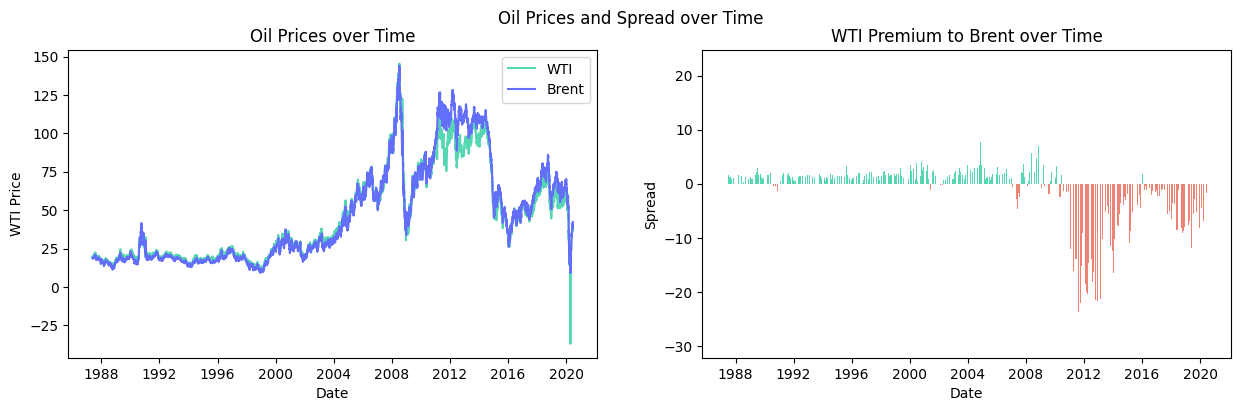

In [93]:
# Graph the price of each of the oil types, as well as the premium of WTI to Brent
fig, axes = plt.subplots(1, 2, figsize=(15, 4))  
axes = axes.flatten()

axes[0].plot(oil_data.index, oil_data["WTI"], label = "WTI", color = GREEN)
axes[0].plot(oil_data.index, oil_data["Brent"], label = "Brent", color = BLUE)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('WTI Price')
axes[0].set_title('Oil Prices over Time')
axes[0].legend()

data_sub = oil_data[oil_data["Spread"] > -30]
color_seq = list(data_sub["Spread"].apply(lambda x: RED if x<0 else GREEN))
axes[1].bar(data_sub.index, data_sub["Spread"], color = color_seq)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Spread")
axes[1].set_title('WTI Premium to Brent over Time')

fig.suptitle("Oil Prices and Spread over Time")

plt.show()

### 01-A2: EDA of 1-Day Percent Change in Oil Prices

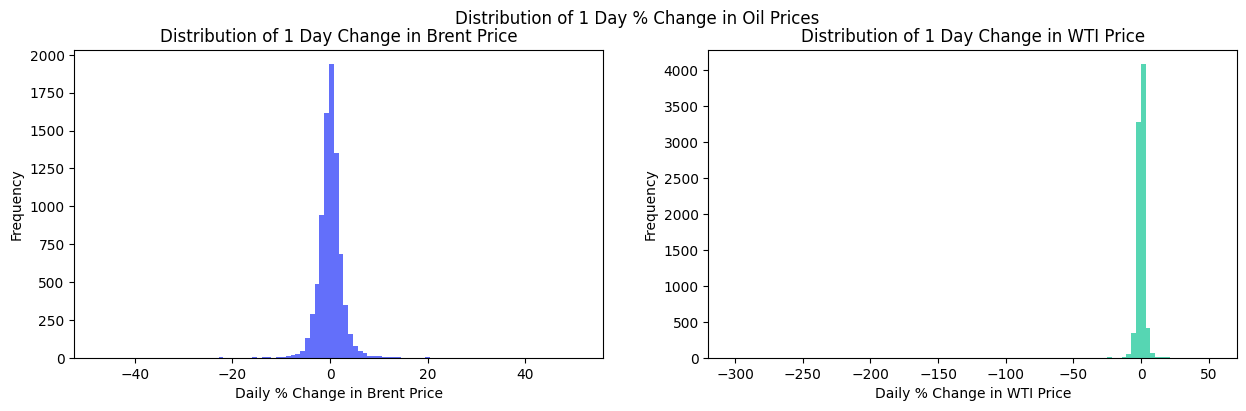

In [94]:
# Below we plot histograms of the 1 day percent change in price of Brent and WTI

fig, axes = plt.subplots(1, 2, figsize=(15, 4))  
axes = axes.flatten()

axes[0].hist( oil_data["Brent_Daily_Change"]*100, color = BLUE, bins = 100)
axes[0].set_xlabel('Daily % Change in Brent Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of 1 Day Change in Brent Price')

axes[1].hist( oil_data["WTI_Daily_Change"]*100, color = GREEN, bins = 100)
axes[1].set_xlabel('Daily % Change in WTI Price')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of 1 Day Change in WTI Price')

fig.suptitle("Distribution of 1 Day % Change in Oil Prices")

plt.show()

## 01-B: Loading Price Data

In [95]:
# Pull Stock Data for the following: 

# Exxon Mobil - NYSE: XOM
# Chevron - NYSE: CVX
# Shell - NYSE: SHEL
# Total Energies - NYSE: TTE
# ConocoPhillips - NYSE: COP
# BP - NYSE: BP
# Equinor ASA - NYSE: EQNR
# Canadian Natural Resources - NYSE: CNQ
# Marathon Petroleum - NYSE: MPC


# IMPORTANT: Keep this set to false unless the data file is corrupted or you dont have it. YF API limits are super stringent
REFRESH_PRICE_DATA_PULL = False
REFRESH_SHARE_DATA_PULL = False
tickers = ["XOM", 'CVX', 'COP', 'BP', 'EQNR', 'CNQ', 'MPC']
tickers_to_names = {"XOM" : "Exxon Mobil",
                    'CVX' : "Chevron",
                    'COP' : "Conoco Phillips",
                    'BP' : "British Petroleum",
                    'EQNR':  "Equinor ASA",
                    'CNQ' : "Canadian Natural Resources",
                    'MPC' : "Marathon Petroleum"}

In [96]:
# Toggle pulling the data again with the flag in the previous cell
if REFRESH_PRICE_DATA_PULL == True:

    # Use YF Database to pull stock data
    def get_price_data(tickers, start_date, end_date):
        """
        Get price time series data for each ticker between specified dates.

        Parameters:
            tickers (list): List of ticker symbols.
            start_date (str): Start date in 'YYYY-MM-DD' format.
            end_date (str): End date in 'YYYY-MM-DD' format.

        Returns:
            dict: Dictionary containing price data for each ticker.
        """
        price_data = {}
        for ticker in tickers:
            try:
                data = yf.download(ticker, start=start_date, end=end_date)
                price_data[ticker] = data
            except Exception as e:
                print(f"Error fetching data for {ticker}: {e}")
        return price_data


    # Pull stock data for specified tickers
    START_DATE = '2015-11-04'
    END_DATE = '2020-06-19'

    # This returns a dictionary that has tickername: Dataframe of stock prices + various other data
    price_data = get_price_data(tickers, START_DATE, END_DATE)

    
    def save_price_data(price_data, filename):
        """
        Save price data dictionary to a file using pickle.

        Parameters:
            price_data (dict): Dictionary containing price data for each ticker.
            filename (str): Name of the file to save.
        """
        with open(filename, 'wb') as f:
            pickle.dump(price_data, f)

    # Saves the dictionary to a pkl file for easy data pull without hitting API refresh limit
    save_price_data(price_data, 'price_data.pkl')


In [97]:
# Toggle pulling the data again with the flag in the previous cell
if REFRESH_SHARE_DATA_PULL == True:
    # Use YF Database to pull stock data
    def get_share_data(tickers, start_date, end_date):
        """
        Get price time series data for each ticker between specified dates.

        Parameters:
            tickers (list): List of ticker symbols.
            start_date (str): Start date in 'YYYY-MM-DD' format.
            end_date (str): End date in 'YYYY-MM-DD' format.

        Returns:
            dict: Dictionary containing price data for each ticker.
        """
        price_data = {}
        for ticker in tickers:
            try:
                tkr = yf.Ticker(ticker)
                data = tkr.get_shares_full(start=start_date, end=end_date)
                price_data[ticker] = data
            except Exception as e:
                print(f"Error fetching data for {ticker}: {e}")
        return price_data


    # Pull stock data for specified tickers
    start_date = '2015-11-04'
    end_date = '2020-06-19'

    # This returns a dictionary that has tickername: Dataframe of stock prices + various other data
    share_data = get_share_data(tickers, start_date, end_date)

    # Saves the dictionary to a pkl file for easy data pull without hitting API refresh limit
    save_price_data(share_data, 'share_data.pkl')

In [98]:
def load_data_from_file(filename):
    """
    Load price data dictionary from a file using pickle.

    Parameters:
        filename (str): Name of the file to load.

    Returns:
        dict: Dictionary containing price data for each ticker.
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)


# Pull Data from local file

path_to_price_data = 'price_data.pkl'
price_data = load_data_from_file(path_to_price_data)

path_to_share_data = 'share_data.pkl'
share_data = load_data_from_file(path_to_share_data)

# clean up share_data + price_data

START_DATE = '2015-11-04'
END_DATE = '2020-06-19'

full_date_range =  pd.date_range(start=START_DATE, end=END_DATE, freq='D')

for ticker in tickers:

    share_data[ticker] = (share_data[ticker]
                          .reset_index()
                          .drop_duplicates(subset='index', keep='last')
                          .set_index('index'))

    share_data[ticker] = (share_data[ticker]
                          .tz_localize(None)
                          .reindex(full_date_range)
                          .ffill()
                          .bfill())

    
    price_data[ticker] = (price_data[ticker]
                          .tz_localize(None)
                          .reindex(full_date_range)
                          .ffill()
                          .bfill())


    #additions

    # print(price_data[ticker])
    


### O1-B1: EDA of Price Time Series and Return Distributions

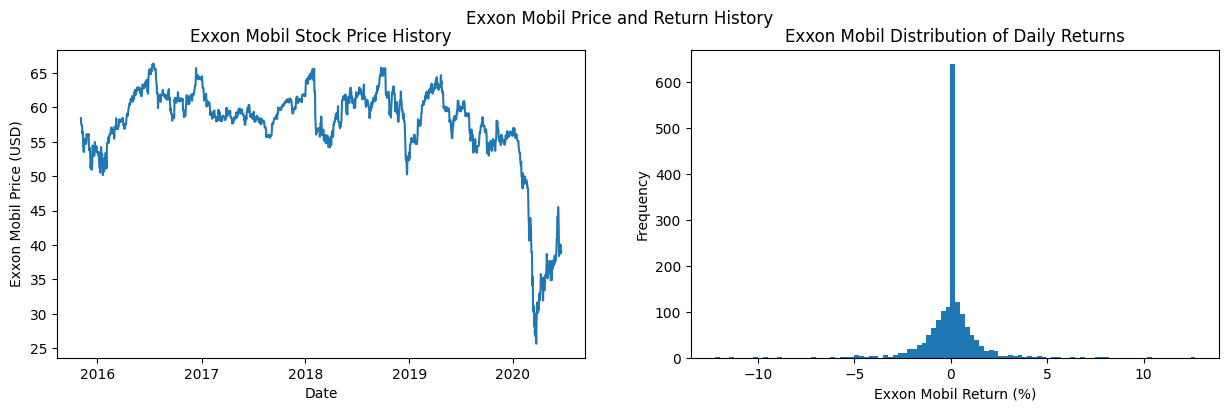

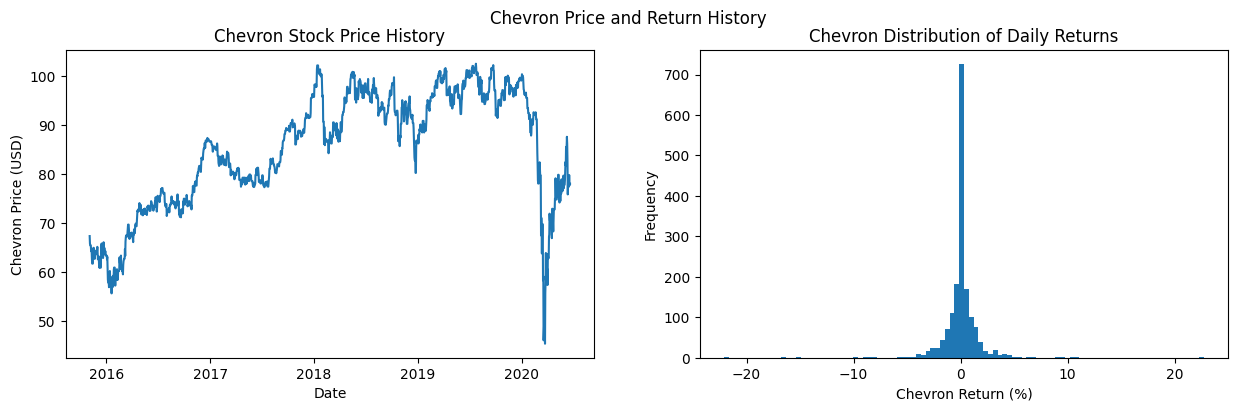

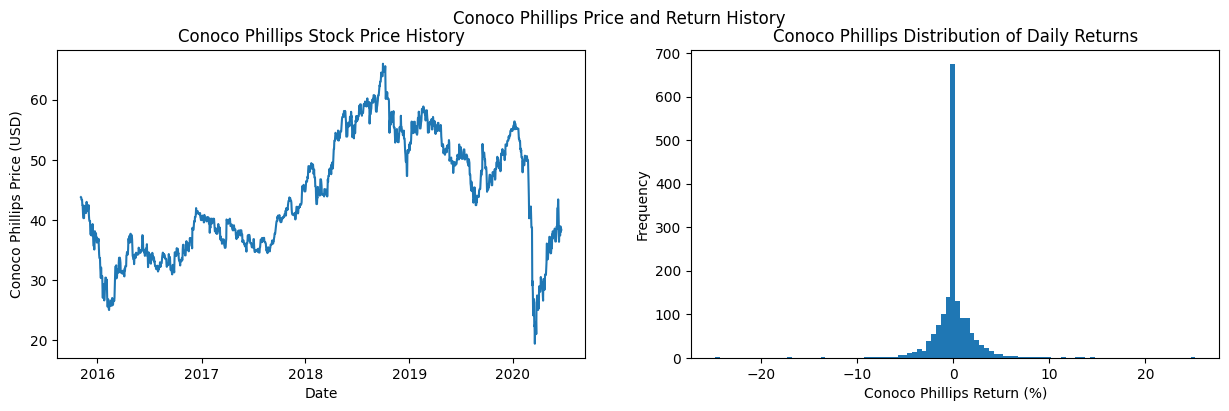

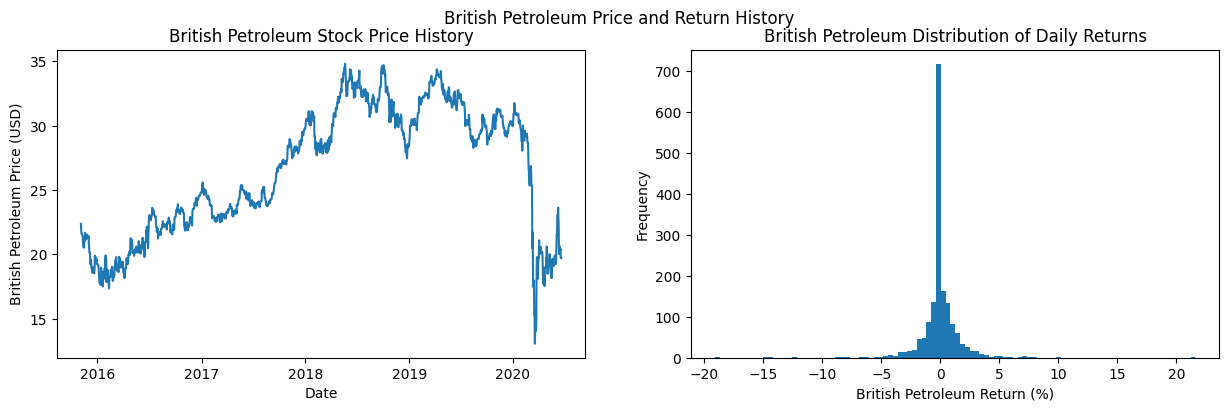

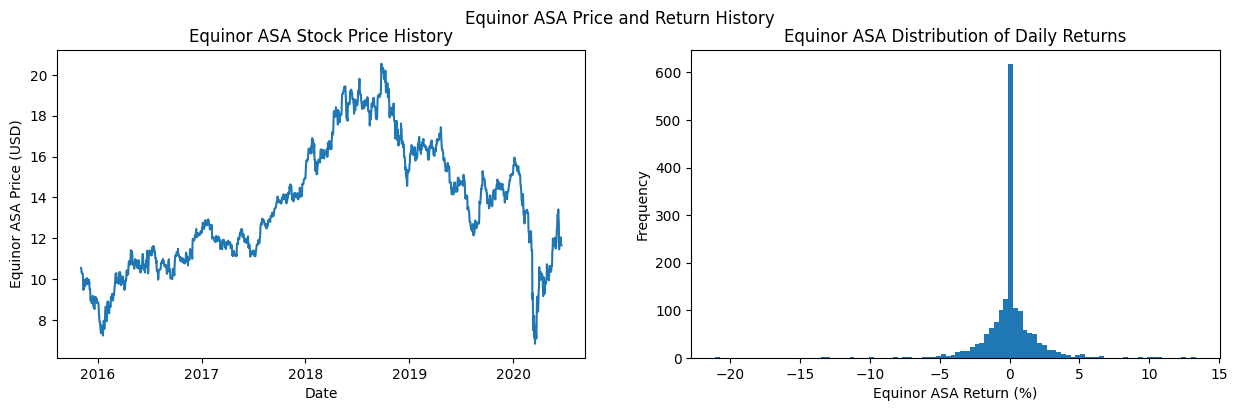

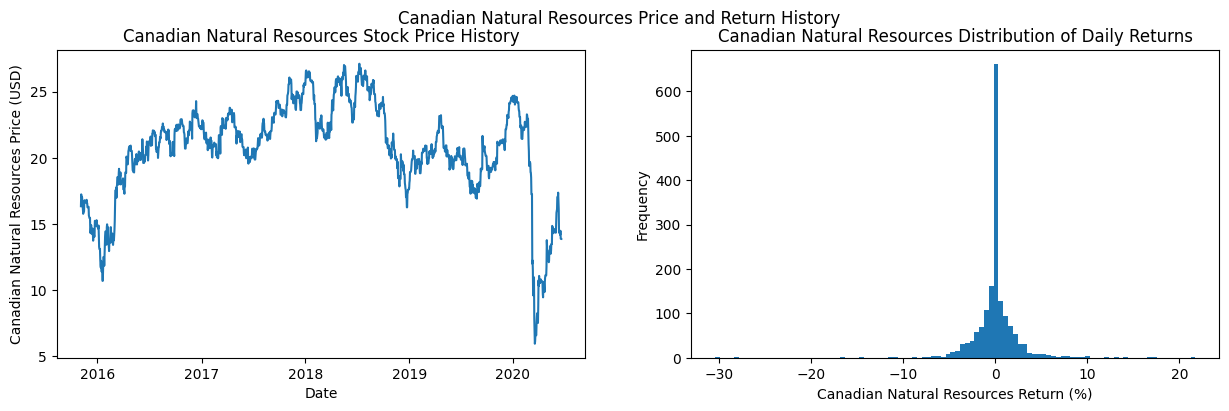

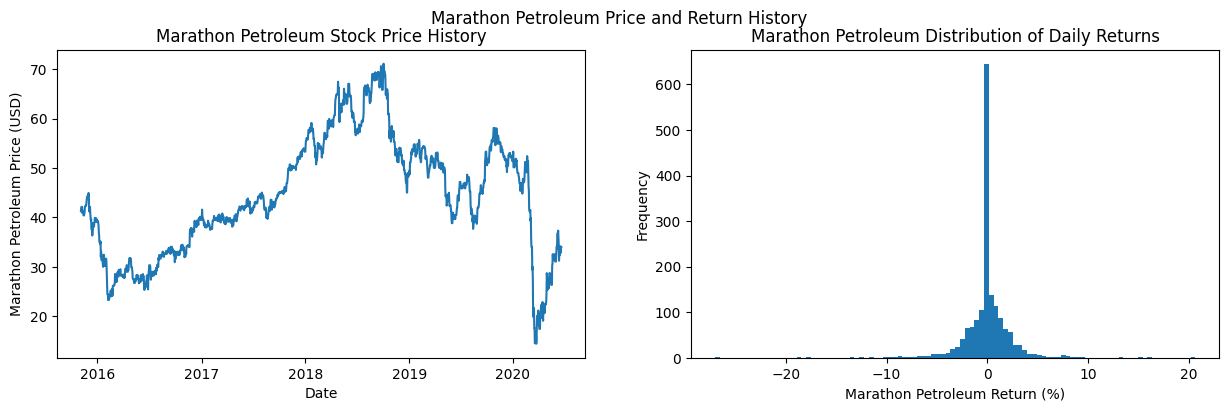

In [139]:
for tkr in tickers:
    data = price_data[tkr]
    data = data[data.index > "2004-01-01"]
    data = data.sort_index()
    data["Daily Return"] = data["Adj Close"].pct_change()
    price_data[tkr] = data

    fig, ax = plt.subplots(1, 2, figsize = (15, 4))
    ax = ax.flatten()

    ax[0].plot(data.index, data["Adj Close"])
    ax[0].set_title(f"{tickers_to_names[tkr]} Stock Price History")
    ax[0].set_xlabel(f"Date")
    ax[0].set_ylabel(f"{tickers_to_names[tkr]} Price (USD)")

    ax[1].hist( data["Daily Return"] * 100, bins = 100)
    ax[1].set_title(f"{tickers_to_names[tkr]} Distribution of Daily Returns")
    ax[1].set_xlabel(f"{tickers_to_names[tkr]} Return (%)")
    ax[1].set_ylabel(f"Frequency")

    fig.suptitle(f"{tickers_to_names[tkr]} Price and Return History")


    


# 02: Construct Index

In [100]:
# index_price_data = {"Date" : price_data["XOM"].index}

# for ticker in tickers:
#     index_price_data[f"{ticker} Price"] = price_data[ticker]["Adj Close"]

# index_share_data = {"Date" : share_data["XOM"].index}
# for ticker in tickers:
#     index_share_data[f"{ticker} Price"] = share_data[ticker]

# print(price_data["CVX"])

# for ticker in share_data:
#     share_data[ticker] = pd.DataFrame(list(share_data[ticker].items()), columns=['Date', 'Share Count'])
#     share_data[ticker].set_index('Date', inplace=True)
#     share_data[ticker].index = share_data[ticker].index.normalize()  # Normalize the date index

# share_data["XOM"] = pd.Series(share_data["XOM"]["Share Count"])
# print(type(share_data["XOM"]))
# print(type(share_data["XOM"]))
# share_data["XOM"] = share_data["XOM"].tz_localize(None)
# print(share_data["XOM"])
# s = pd.Series((share_data["XOM"]))
# s = s.tz_localize(None)
# print(s)

columns = []
for ticker in tickers_to_names.keys():
    columns.extend([
        f"{ticker} Price",
        f"{ticker} Share Count",
        f"{ticker} Market Cap"
    ])

columns.extend(["Index", "Total Market Cap"])

START_DATE = '2015-11-04'
END_DATE = '2020-06-19'

data = {col: [None] * len(pd.date_range(start=START_DATE, end=END_DATE)) for col in columns}

index_df = pd.DataFrame(data)
dates = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
index_df.index = dates

import numpy as np

for ticker in tickers:
    index_df[f"{ticker} Price"] = price_data[ticker]["Adj Close"].reindex(full_date_range)
    index_df[f"{ticker} Share Count"] = share_data[ticker].reindex(full_date_range)
    index_df[f"{ticker} Market Cap"] = index_df[f"{ticker} Price"] * index_df[f"{ticker} Share Count"]

# Calculate Total Market Cap
index_df["Total Market Cap"] = index_df[[f"{ticker} Market Cap" for ticker in tickers]].sum(axis=1)

# Calculate Index
index_df["Index"] = sum((index_df[f"{ticker} Market Cap"] / index_df["Total Market Cap"]) * index_df[f"{ticker} Price"] for ticker in tickers)


index_df

,XOM Price,XOM Share Count,XOM Market Cap,CVX Price,CVX Share Count,CVX Market Cap,COP Price,COP Share Count,COP Market Cap,BP Price,...,EQNR Share Count,EQNR Market Cap,CNQ Price,CNQ Share Count,CNQ Market Cap,MPC Price,MPC Share Count,MPC Market Cap,Index,Total Market Cap
2015-11-04,58.424702,4.162940e+09,2.432185e+11,67.289986,1.882040e+09,1.266424e+11,43.775261,1.243700e+09,5.444329e+10,22.374241,...,3.337010e+09,3.518574e+10,16.343693,1.157460e+09,1.891717e+10,41.254074,543200000.0,2.240921e+10,49.556121,5.707578e+11
2015-11-05,57.629658,4.162940e+09,2.399088e+11,65.746277,1.882040e+09,1.237371e+11,43.728645,1.243700e+09,5.438532e+10,21.875797,...,3.337010e+09,3.495257e+10,17.239332,1.157460e+09,1.995384e+10,41.893959,543200000.0,2.275680e+10,48.749870,5.640778e+11
2015-11-06,57.398643,4.162940e+09,2.389471e+11,65.384697,1.882040e+09,1.230566e+11,43.332394,1.243700e+09,5.389250e+10,21.617350,...,3.337010e+09,3.440147e+10,17.037310,1.157460e+09,1.972000e+10,42.134865,543200000.0,2.288766e+10,48.551788,5.604808e+11
2015-11-07,57.398643,4.162940e+09,2.389471e+11,65.384697,1.882040e+09,1.230566e+11,43.332394,1.243700e+09,5.389250e+10,21.617350,...,3.337010e+09,3.440147e+10,17.037310,1.157460e+09,1.972000e+10,42.134865,543200000.0,2.288766e+10,48.551788,5.604808e+11
2015-11-08,57.398643,4.162940e+09,2.389471e+11,65.384697,1.882040e+09,1.230566e+11,43.332394,1.243700e+09,5.389250e+10,21.617350,...,3.337010e+09,3.440147e+10,17.037310,1.157460e+09,1.972000e+10,42.134865,543200000.0,2.288766e+10,48.551788,5.604808e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-15,39.187004,4.230430e+09,1.657779e+11,77.369820,1.866980e+09,1.444479e+11,37.390591,1.072430e+09,4.009879e+10,20.282932,...,3.410880e+09,4.086308e+10,14.181081,1.176590e+09,1.668532e+10,33.458611,650260992.0,2.175683e+10,44.246313,4.970722e+11
2020-06-16,40.068169,4.230430e+09,1.695056e+11,79.744438,1.866980e+09,1.488813e+11,38.908634,1.072430e+09,4.172679e+10,20.441130,...,3.181250e+09,3.831265e+10,14.487084,1.174530e+09,1.701552e+10,34.165977,650260992.0,2.221680e+10,45.812320,5.048443e+11
2020-06-17,38.763046,4.230430e+09,1.639844e+11,77.632729,1.866980e+09,1.449387e+11,37.968483,1.072430e+09,4.071854e+10,19.733397,...,3.284480e+09,3.870160e+10,13.891178,1.176980e+09,1.634964e+10,32.830811,650260992.0,2.134860e+10,44.378968,4.922318e+11
2020-06-18,39.004108,4.230430e+09,1.650041e+11,77.971970,1.866980e+09,1.455721e+11,38.339367,1.072430e+09,4.111629e+10,19.725073,...,3.327590e+09,3.876371e+10,13.867021,1.183010e+09,1.640482e+10,34.015656,650260992.0,2.211905e+10,44.579521,4.961904e+11


# 03: Fitting Model for Whole Index

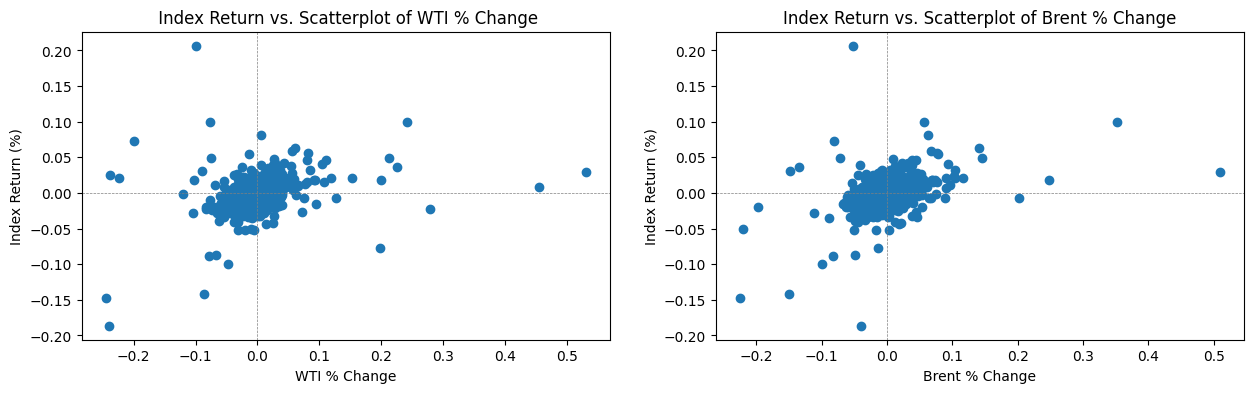

In [101]:
index_df["Index Return"] = index_df["Index"].pct_change()
data = index_df.merge(oil_data, left_index=True, right_index=True, how= "inner")
data = data[data["WTI_Daily_Change"] > -1]
data = data.sort_index()

fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax = ax.flatten()

ax[0].scatter(data["WTI_Daily_Change"], data["Index Return"])
ax[0].set_title(f" Index Return vs. Scatterplot of WTI % Change")
ax[0].set_xlabel(f"WTI % Change")
ax[0].set_ylabel(f"Index Return (%)")
ax[0].axhline(0, color='grey', linewidth=0.5, linestyle='--')  
ax[0].axvline(0, color='grey', linewidth=0.5, linestyle='--') 

ax[1].scatter(data["Brent_Daily_Change"], data["Index Return"])
ax[1].set_title(f"Index Return vs. Scatterplot of Brent % Change")
ax[1].set_xlabel(f"Brent % Change")
ax[1].set_ylabel(f"Index Return (%)")
ax[1].axhline(0, color='grey', linewidth=0.5, linestyle='--')  
ax[1].axvline(0, color='grey', linewidth=0.5, linestyle='--')  



# 04: Principal Components Regression

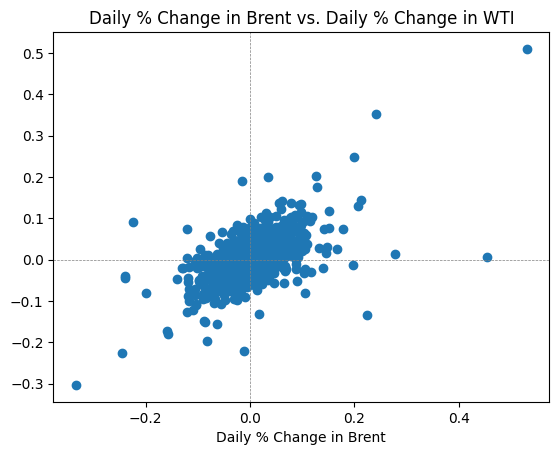

In [102]:
oil_data = oil_data[oil_data["Brent_Daily_Change"] > -1]
oil_data = oil_data[oil_data["WTI_Daily_Change"] > -1]

plt.scatter(oil_data["WTI_Daily_Change"], oil_data["Brent_Daily_Change"])
plt.title("Daily % Change in Brent vs. Daily % Change in WTI")
plt.xlabel("Daily % Change in WTI")
plt.xlabel("Daily % Change in Brent")
plt.axhline(0, color='grey', linewidth=0.5, linestyle='--')  
plt.axvline(0, color='grey', linewidth=0.5, linestyle='--') 
plt.show()


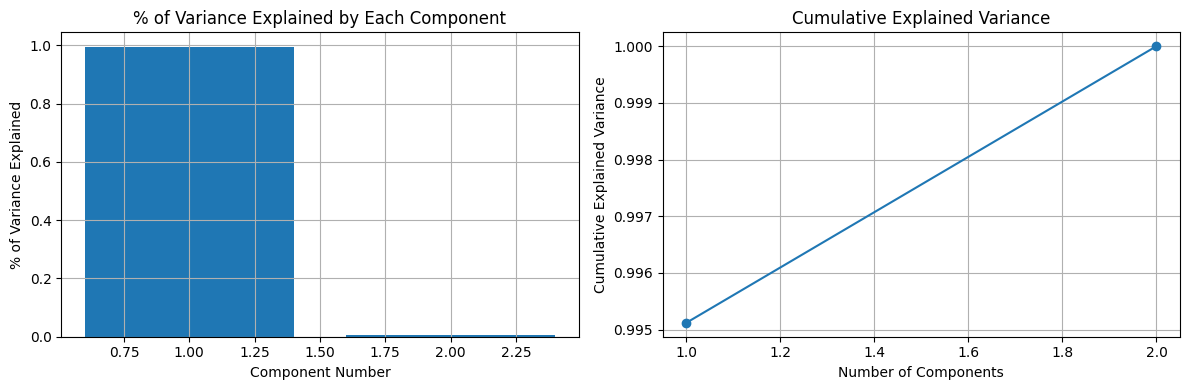

In [103]:
data = oil_data[["WTI", "Brent"]]

pca = PCA()
pca.fit(data)


explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)


plt.figure(figsize=(12, 4))

# Plot % of variance explained by each component
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center')
plt.title('% of Variance Explained by Each Component')
plt.xlabel('Component Number')
plt.ylabel('% of Variance Explained')
plt.grid(True)

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()



In [104]:
class PrincipalComponentsRegression:
    def __init__(self, n_components=None):
        self.pca = PCA(n_components=n_components)
        self.model = LinearRegression()

    def fit(self, X, y):
        X_pca = self.pca.fit_transform(X)
        self.model.fit(X_pca, y)

    def predict(self, X_new):
        X_new_pca = self.pca.transform(X_new)
        return self.model.predict(X_new_pca)

# 05: Fitting Models for Single Stocks

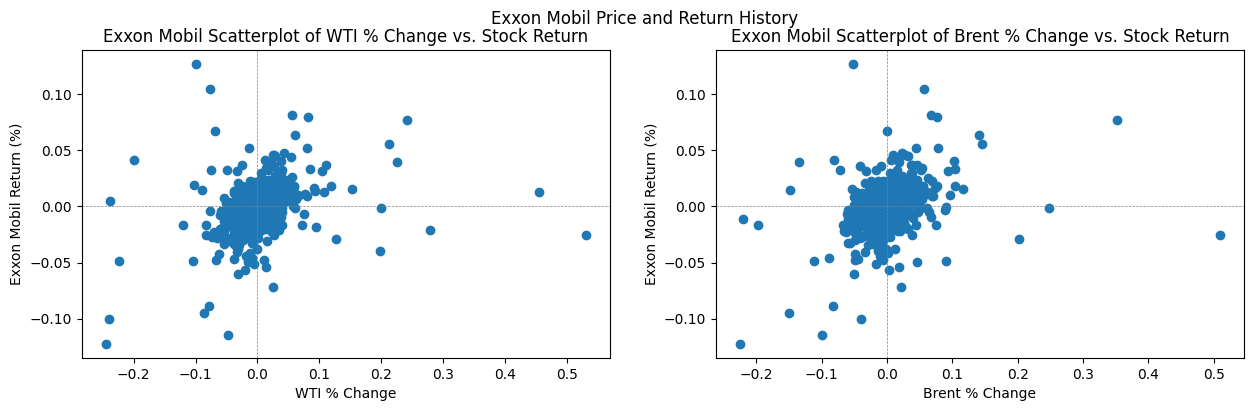

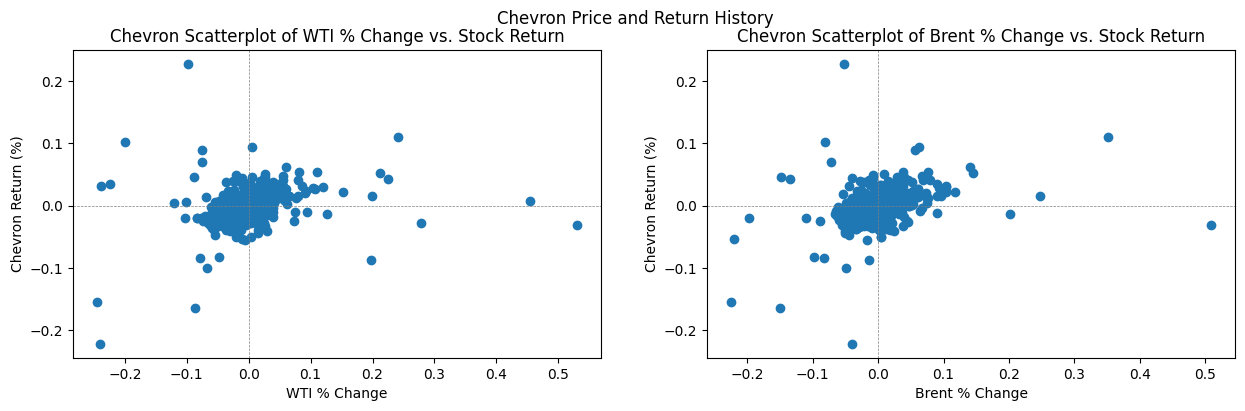

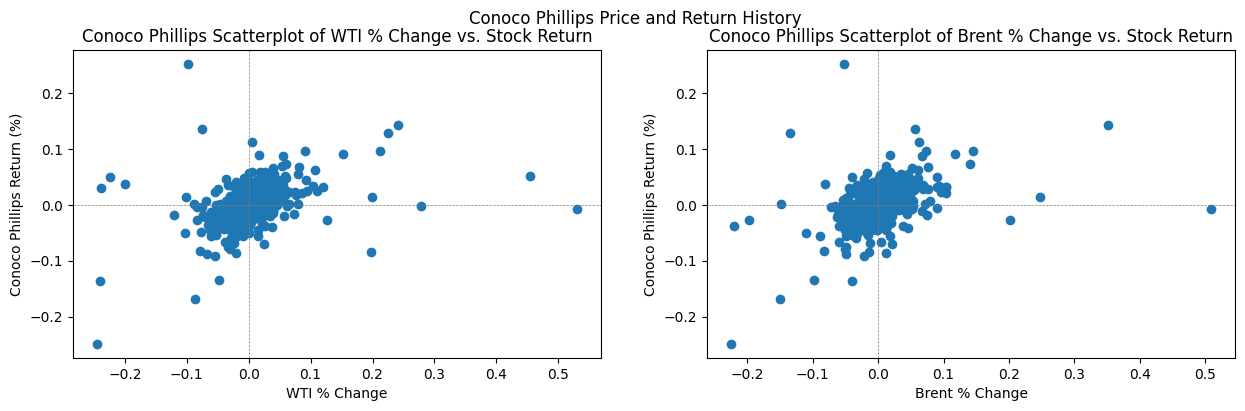

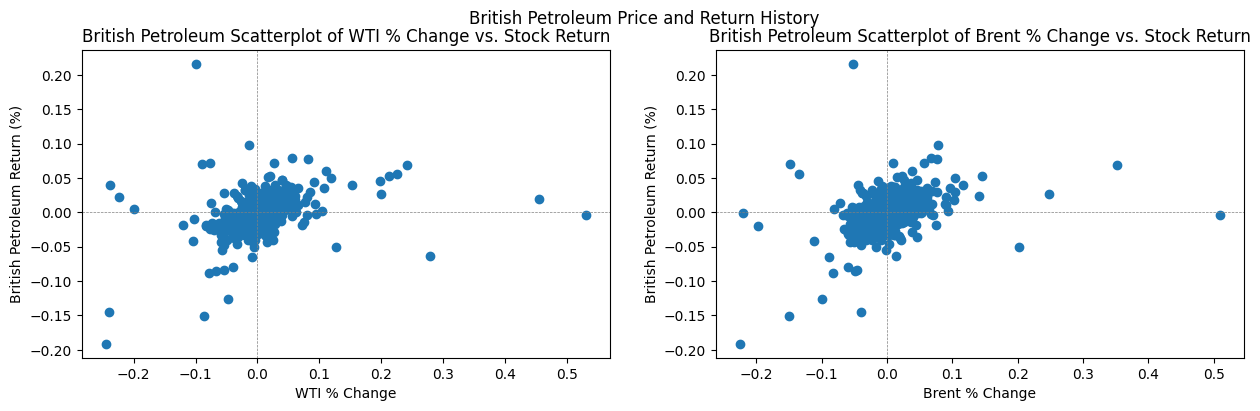

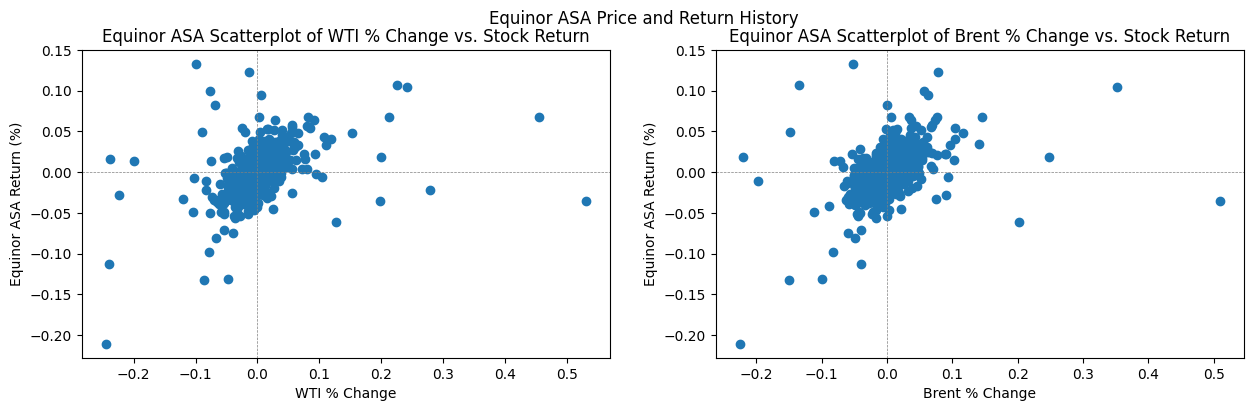

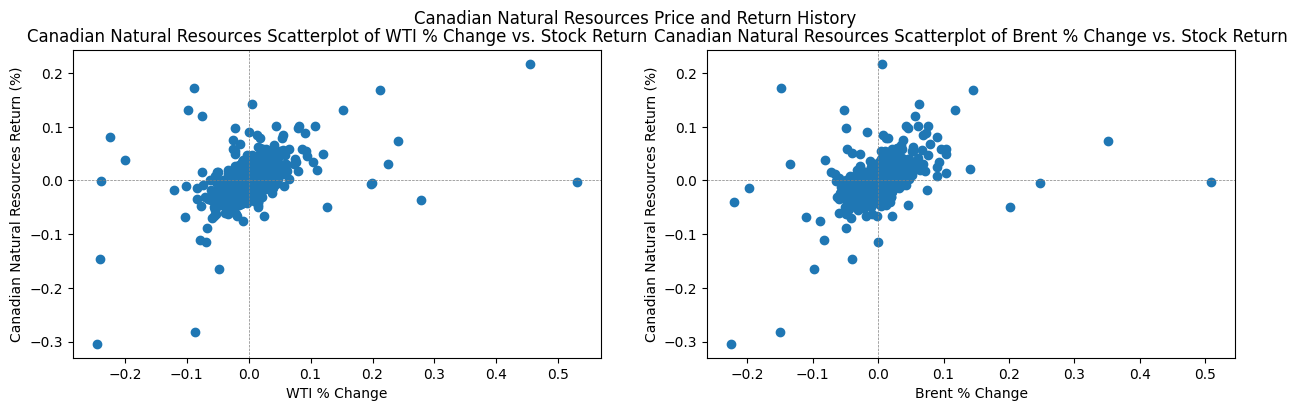

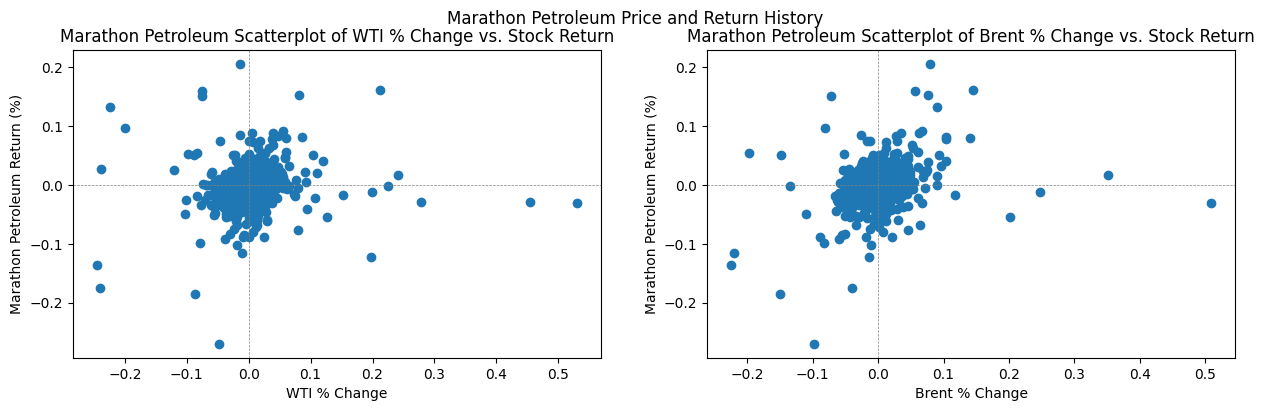

In [105]:
for tkr in tickers:
    data = price_data[tkr]
    data = data[data.index > "2004-01-01"]

    data = data.merge(oil_data, left_index=True, right_index=True, how= "inner")
    data = data[data["WTI_Daily_Change"] > -1]

    data = data.sort_index()
    data["Daily Return"] = data["Adj Close"].pct_change()


    fig, ax = plt.subplots(1, 2, figsize = (15, 4))
    ax = ax.flatten()

    ax[0].scatter(data["WTI_Daily_Change"], data["Daily Return"])
    ax[0].set_title(f"{tickers_to_names[tkr]} Scatterplot of WTI % Change vs. Stock Return")
    ax[0].set_xlabel(f"WTI % Change")
    ax[0].set_ylabel(f"{tickers_to_names[tkr]} Return (%)")
    ax[0].axhline(0, color='grey', linewidth=0.5, linestyle='--')  
    ax[0].axvline(0, color='grey', linewidth=0.5, linestyle='--') 
    
    ax[1].scatter(data["Brent_Daily_Change"], data["Daily Return"])
    ax[1].set_title(f"{tickers_to_names[tkr]} Scatterplot of Brent % Change vs. Stock Return")
    ax[1].set_xlabel(f"Brent % Change")
    ax[1].set_ylabel(f"{tickers_to_names[tkr]} Return (%)")
    ax[1].axhline(0, color='grey', linewidth=0.5, linestyle='--')  
    ax[1].axvline(0, color='grey', linewidth=0.5, linestyle='--')  

    fig.suptitle(f"{tickers_to_names[tkr]} Price and Return History")

# 06: ARIMAX (Autoregressive Integrated Moving Average with Exogenous Variables)

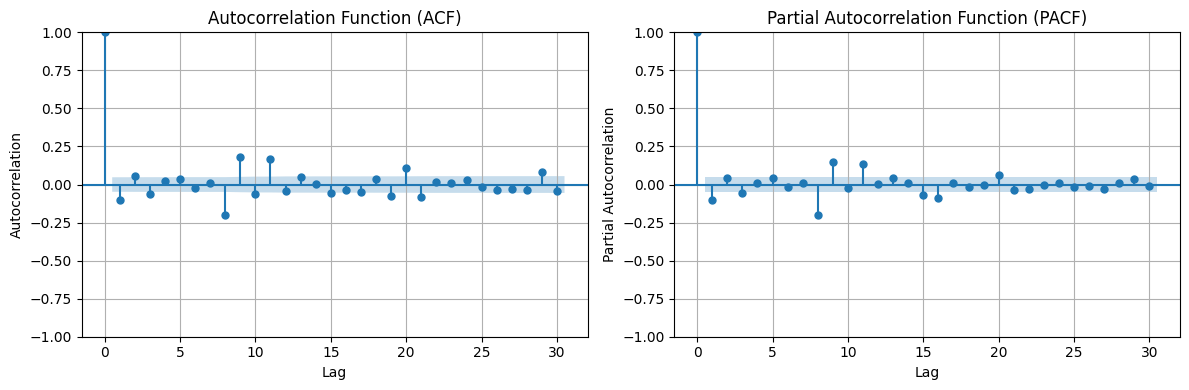

In [106]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF
plot_acf(index_df["Index Return"].dropna(), lags=30, ax=ax[0])  
ax[0].set_title('Autocorrelation Function (ACF)')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')
ax[0].grid(True)

# Plot PACF
plot_pacf(index_df["Index Return"].dropna(), lags=30, ax=ax[1])  
ax[1].set_title('Partial Autocorrelation Function (PACF)')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].grid(True)

plt.tight_layout()
plt.show()


# 06: Model Evaluation + Time Series Cross Validation

In [113]:
def train_val_test_split(data, val_size, test_size):

    data_length = len(data)
    random_index = np.random.permutation(data_length)

    val_size = int(data_length * val_size)
    test_size = int(data_length * test_size)

    test_indices = random_index[:test_size]
    remaining_indices = random_index[test_size:]
    val_indices = remaining_indices[:val_size]
    train_indices = remaining_indices[val_size:]

    train_data = data.iloc[train_indices]
    val_data = data.iloc[val_indices]
    test_data = data.iloc[test_indices]

    return train_data, val_data, test_data

index_df["Index Return"] = index_df["Index"].pct_change()
data = index_df.merge(oil_data, left_index=True, right_index=True, how= "inner")
data = data[data["WTI_Daily_Change"] > -1]
data = data.sort_index()



In [137]:
def eval_model(model, data, name, predictors, target):
    train_data, val_data, test_data = train_val_test_split(data.dropna(), 0.1, 0.1)

    model.fit(train_data[predictors], train_data[target])

    predictions_train = model.predict(train_data[predictors])
    train_error = mean_squared_error(train_data[target], predictions_train)
    train_r2_score = round(r2_score(train_data[target], predictions_train), 4)

    predictions_val = model.predict(val_data[predictors])
    val_error = mean_squared_error(val_data[target], predictions_val)
    val_r2_score = round(r2_score(val_data[target], predictions_val), 4)
    
    predictions_test = model.predict(test_data[predictors])
    test_error = mean_squared_error(test_data[target], predictions_test)
    test_r2_score = round(r2_score(test_data[target], predictions_test), 4)


    print(f"Results for {name}: \n  - Training Data: MSE = {train_error:.2e}; R2 = {train_r2_score}\n  - Validation Data: MSE = {val_error:.2e}; R2 = {val_r2_score}\n  - Test Data: MSE = {test_error:.2e}; R2 = {test_r2_score} \n")

In [138]:
# Fit Vanilla Linear Regression
index_model = LinearRegression()
eval_model(index_model,
            data,
            name ="Vanilla Linear Regression",
            predictors =["WTI_Daily_Change","Brent_Daily_Change"],
            target="Index Return")

# Fit Principal Components Regression
PCR_Model = PrincipalComponentsRegression(1)
eval_model(PCR_Model,
            data,
            name ="Principal Components Regression",
            predictors =["WTI_Daily_Change","Brent_Daily_Change"],
            target="Index Return")


Results for Vanilla Linear Regression: 
  - Training Data: MSE = 2.86e-04; R2 = 0.1509
  - Validation Data: MSE = 1.51e-04; R2 = 0.0999
  - Test Data: MSE = 3.68e-04; R2 = 0.2438 

Results for Principal Components Regression: 
  - Training Data: MSE = 2.96e-04; R2 = 0.187
  - Validation Data: MSE = 3.18e-04; R2 = -0.265
  - Test Data: MSE = 2.16e-04; R2 = -0.1978 



In [141]:
# Fit Linear Regressions For each Individual Stock
for tkr in tickers:
    ticker_data = price_data[tkr]
    data = ticker_data.merge(oil_data, left_index=True, right_index=True, how= "inner")
    model = LinearRegression()
    eval_model(model,
            data,
            name =f"Linear Regression - {tickers_to_names[tkr]}",
            predictors =["WTI_Daily_Change","Brent_Daily_Change"],
            target="Daily Return")
    


Results for Linear Regression - Exxon Mobil: 
  - Training Data: MSE = 2.34e-04; R2 = 0.1624
  - Validation Data: MSE = 2.98e-04; R2 = 0.0872
  - Test Data: MSE = 1.77e-04; R2 = 0.2297 

Results for Linear Regression - Chevron: 
  - Training Data: MSE = 2.94e-04; R2 = 0.1909
  - Validation Data: MSE = 8.55e-04; R2 = -0.1098
  - Test Data: MSE = 2.38e-04; R2 = 0.3478 

Results for Linear Regression - Conoco Phillips: 
  - Training Data: MSE = 5.06e-04; R2 = 0.2908
  - Validation Data: MSE = 9.56e-04; R2 = -0.5063
  - Test Data: MSE = 4.17e-04; R2 = 0.2912 

Results for Linear Regression - British Petroleum: 
  - Training Data: MSE = 3.44e-04; R2 = 0.2089
  - Validation Data: MSE = 1.63e-04; R2 = 0.1831
  - Test Data: MSE = 3.17e-04; R2 = 0.1628 

Results for Linear Regression - Equinor ASA: 
  - Training Data: MSE = 3.96e-04; R2 = 0.2563
  - Validation Data: MSE = 2.61e-04; R2 = 0.3042
  - Test Data: MSE = 2.93e-04; R2 = 0.1408 

Results for Linear Regression - Canadian Natural Resource

In [142]:
# Fit Principal Component Regressions For each Individual Stock
for tkr in tickers:
    ticker_data = price_data[tkr]
    data = ticker_data.merge(oil_data, left_index=True, right_index=True, how= "inner")
    model = PrincipalComponentsRegression()
    eval_model(model,
            data,
            name =f"Linear Regression - {tickers_to_names[tkr]}",
            predictors =["WTI_Daily_Change","Brent_Daily_Change"],
            target="Daily Return")

Results for Linear Regression - Exxon Mobil: 
  - Training Data: MSE = 2.34e-04; R2 = 0.1453
  - Validation Data: MSE = 2.46e-04; R2 = 0.1606
  - Test Data: MSE = 2.49e-04; R2 = 0.216 

Results for Linear Regression - Chevron: 
  - Training Data: MSE = 3.60e-04; R2 = 0.1582
  - Validation Data: MSE = 3.37e-04; R2 = 0.0303
  - Test Data: MSE = 2.24e-04; R2 = 0.1763 

Results for Linear Regression - Conoco Phillips: 
  - Training Data: MSE = 4.80e-04; R2 = 0.2782
  - Validation Data: MSE = 3.52e-04; R2 = 0.1583
  - Test Data: MSE = 1.11e-03; R2 = 0.0531 

Results for Linear Regression - British Petroleum: 
  - Training Data: MSE = 3.55e-04; R2 = 0.2038
  - Validation Data: MSE = 1.86e-04; R2 = 0.1987
  - Test Data: MSE = 2.02e-04; R2 = 0.214 

Results for Linear Regression - Equinor ASA: 
  - Training Data: MSE = 3.48e-04; R2 = 0.28
  - Validation Data: MSE = 4.93e-04; R2 = -0.1574
  - Test Data: MSE = 4.77e-04; R2 = 0.3197 

Results for Linear Regression - Canadian Natural Resources: 
 